# Instantiation of Julia environment

In [41]:
using Pkg
Pkg.activate("..") #Activate the project environment
Pkg.instantiate() #Install the required packages    
# Load the required packages
using ModelingToolkit, DifferentialEquations, Plots,PhysicsInformedRegression

  Activating project at `c:\Users\Marcu\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression`
  0 dependencies successfully precompiled in 49 seconds. 517 already precompiled.


# SIR model with constant parameters
The following example shows how to use `PhysiscInformedRegression.jl` to solve the inverse problem of a SIR model with constant parameters. 
The compartments of the SIR model are susceptible (S), infected (I), and recovered (R), and the system describes the flow of individuals between these compartments over time. 
The model is parameterized by the transmission rate $\beta$ and the recovery rate $\gamma$ and is given by the following system of ordinary differential equations (ODEs):


In [42]:
### SIR MODEL
@parameters β γ
@independent_variables t
@variables S(t) I(t) R(t)
D = Differential(t)
eqs = [D(S) ~ -β*S*I,
    D(I) ~ β*S*I - γ*I,
    D(R) ~ γ*I]

# Define the system
@named sys = ODESystem(eqs, t)
sys = structural_simplify(sys)

Model sys:
Equations (3):
  3 standard: see equations(sys)
Unknowns (3): see unknowns(sys)
  I(t)
  R(t)
  S(t)
Parameters (2): see parameters(sys)
  β
  γ

# Simulation of the SIR model
The system of ODEs is solved using the `DifferentialEquations.jl` package with fractional population sizes.:
$$
\begin{align*}
S(0) &= 0.99, \\
I(0) &= 0.01, \\
R(0) &= 0.
\end{align*}
$$
and the following parameters:
$$
\begin{align*}
\beta &= 0.5, \\
\gamma &= 0.33.
\end{align*}
$$
The simulation is run for a time span of 80 days with daily observations. The following code snippet shows how to set up and solve the ODEs:


In [43]:
#Define the initial conditions and parameters
u0 = [S => 0.99,
    I => 0.01,
    R => 0.0]

p = Dict([β => 0.5,
    γ => 1/3])


# Define the time span
start = 0
stop = 80
len = 80
timesteps = collect(range(start, stop, length = len))

# Simulate the system
prob = ODEProblem(sys, u0,(start,stop) ,p, saveat = timesteps)
sol = solve(prob)


retcode: Success
Interpolation: 1st order linear
t: 80-element Vector{Float64}:
  0.0
  1.0126582278481013
  2.0253164556962027
  3.037974683544304
  4.050632911392405
  5.063291139240507
  6.075949367088608
  7.0886075949367084
  8.10126582278481
  9.113924050632912
  ⋮
 71.89873417721519
 72.9113924050633
 73.92405063291139
 74.9367088607595
 75.9493670886076
 76.9620253164557
 77.9746835443038
 78.9873417721519
 80.0
u: 80-element Vector{Vector{Float64}}:
 [0.01, 0.0, 0.99]
 [0.011763007299961683, 0.0036658715959091595, 0.9845711211041291]
 [0.013795744935109402, 0.007971625942275039, 0.9782326291226155]
 [0.01612378019757016, 0.013012687716949802, 0.97086353208548]
 [0.01876911574704405, 0.018892608026572992, 0.962338276226383]
 [0.02174734224686624, 0.02572125310706681, 0.952531404646067]
 [0.02506470814312957, 0.033612617764528764, 0.9413226740923417]
 [0.028713631631466088, 0.04268000189763005, 0.9286063664709039]
 [0.032669667642544906, 0.05303165414149075, 0.9142986782159643]


# Physics-informed regression
The `PhysiscInformedRegression.jl` package is used to solve the inverse problem of the SIR model. The system is rewritten as a linear system of equations, and the parameters $\beta$ and $\gamma$ are estimated using the observations. The following code snippet shows how to set up and solve the inverse problem:


In [44]:

# Compute the derivatives
du_finite_approx =  PhysicsInformedRegression.finite_diff(sol.u, sol.t)

# Setup model for regression
using Latexify
using LaTeXStrings
using PhysicsInformedRegression

du_approx = PhysicsInformedRegression.finite_diff(sol.u, sol.t) #approximated derivatives
A,b = PhysicsInformedRegression.setup_linear_system(sys)
A_sym = latexify(A; inline = true)
b_sym = latexify(b; inline = true)
display(A_sym)
display(b_sym)

L"\begin{equation}
\left[
\begin{array}{cc}
S\left( t \right) I\left( t \right) &  - I\left( t \right) \\
0.0 & I\left( t \right) \\
 - S\left( t \right) I\left( t \right) & 0.0 \\
\end{array}
\right]
\end{equation}
"

L"\begin{equation}
\left[
\begin{array}{c}
\frac{\mathrm{d} I\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} R\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} S\left( t \right)}{\mathrm{d}t} \\
\end{array}
\right]
\end{equation}
"

Consequently, the SIR model can be represented as a linear system of equations:
$$
\begin{align*}
    \left[
    \begin{array}{cc}
    S\left( t \right) I\left( t \right) &  - I\left( t \right) \\
    0.0 & I\left( t \right) \\
    - S\left( t \right) I\left( t \right) & 0.0 \\
    \end{array}
    \right] 
    \left[
    \begin{array}{c}
    \beta \\
    \gamma \\
    \end{array}
    \right]
    &=
    \left[
    \begin{array}{c}
    \frac{\mathrm{d} I\left( t \right)}{\mathrm{d}t} \\
    \frac{\mathrm{d} R\left( t \right)}{\mathrm{d}t} \\
    \frac{\mathrm{d} S\left( t \right)}{\mathrm{d}t} \\
    \end{array}
    \right]\\
    A \omega &= b

\end{align*}
$$
The optimal parameters $\omega = \left[ \beta^*, \gamma^* \right]$ can be estimated by minimizing the residuals of the system of equations
$$
\begin{align*}
    \left[\beta^* \\ \gamma^*\right] &= \arg\min_{\omega} \left\| A \omega - b \right\|_2^2\\
    &= (A^T A)^{-1} A^T b
\end{align*}
$$

The OLS estimtator is computed in the following code snippet:




In [45]:
# Estimate the parameters
paramsest = PhysicsInformedRegression.physics_informed_regression(sys, sol.u, du_approx, A, b)

#compare the estimated parameters to the true parameters
parameterdict = Dict(p)
for (i, param) in enumerate(parameters(sys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
end

Parameter β = 0.5 estimated as 0.49962546878725067
Parameter γ = 0.3333333333333333 estimated as 0.3330839774742002


## Illustration of the recovered system
The simulation is run with the recovered parameters, and the results are compared to the original system. The solution is plotted to visualize the accuracy of the recovery. The recovered parameters are expected to be close to the original parameters, and the solution should exhibit similar behavior to the original system.

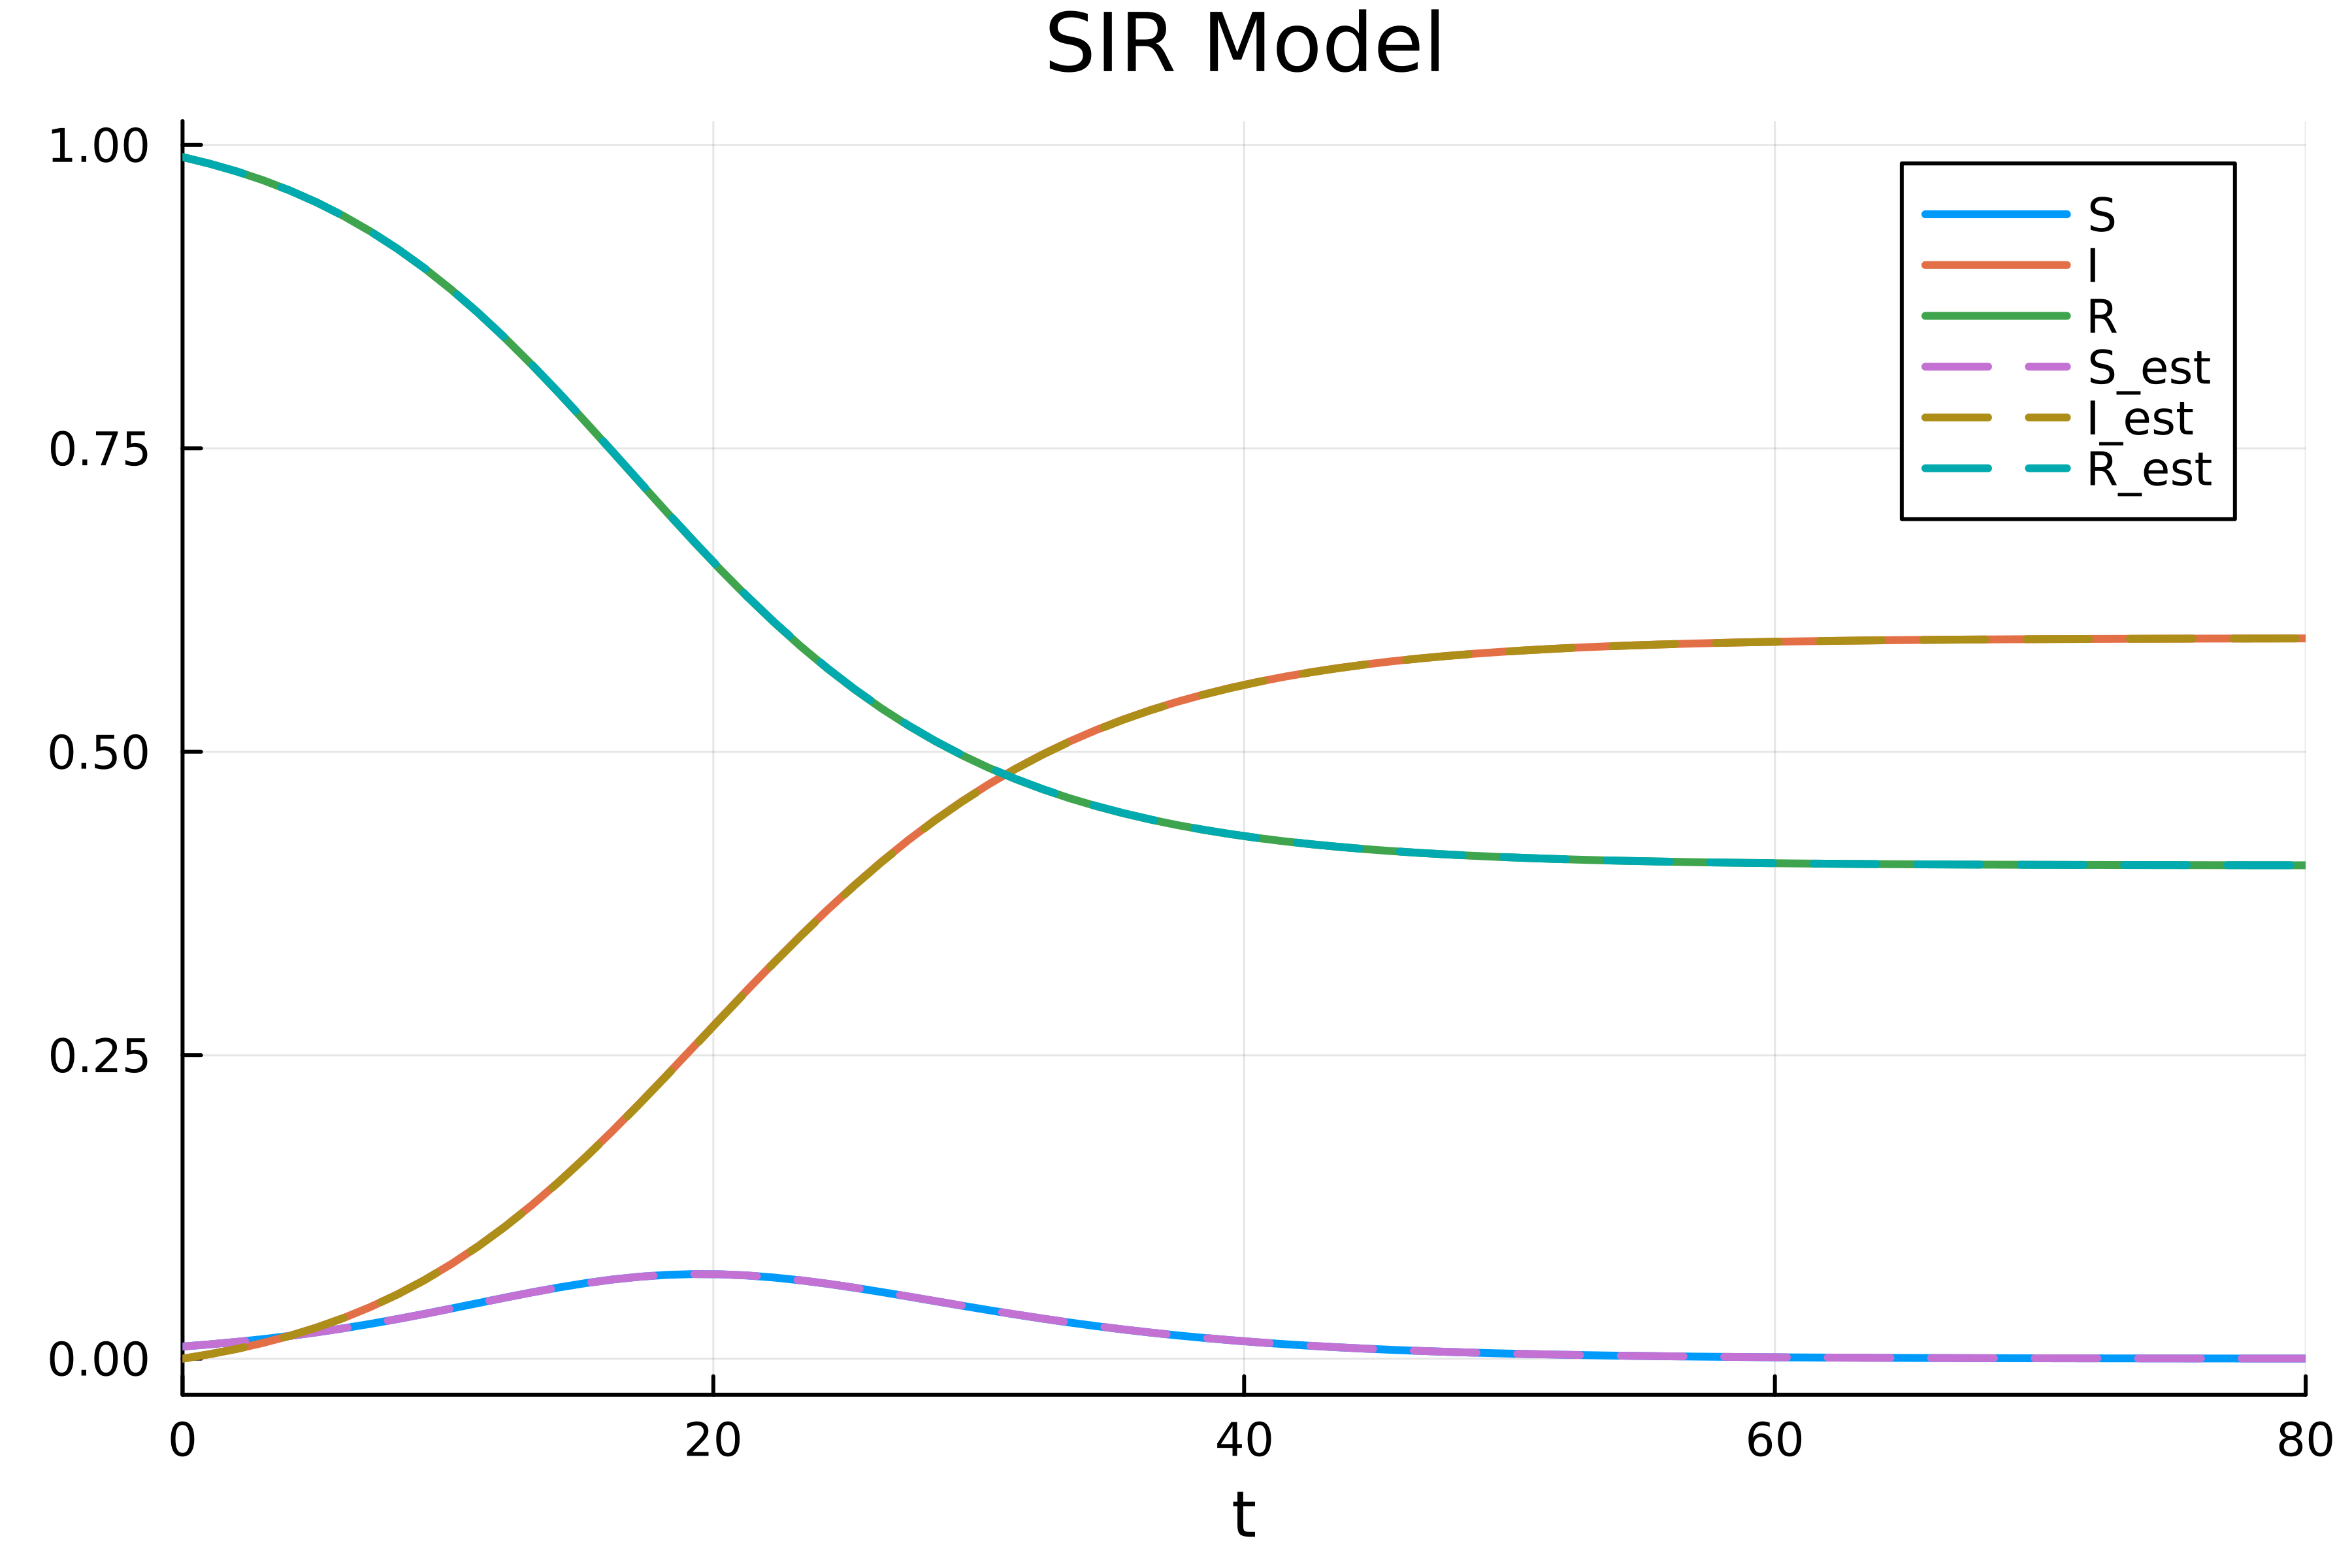

In [46]:
# Plot the results
using Plots
estimated_sol = solve(ODEProblem(sys, u0,(start, stop) ,paramsest), Tsit5(), saveat = timesteps)
plot(sol, label = ["S" "I" "R"], title = "SIR Model", lw = 2, dpi = 600)
plot!(estimated_sol, label = ["S_est" "I_est" "R_est"], lw = 2, ls = :dash, dpi = 600)

# Evaluating the results
The regression is run once again for different numbers of collocation points, and the results are compared to the original parameters. The goal is to see how the number of collocation points affects the accuracy of the recovery. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves. 


In [47]:
using Random
Random.seed!(1234) # Set seed for reproducibility
include("../utils/julia_utils.jl")
export create_table, noise_v_collocation_points

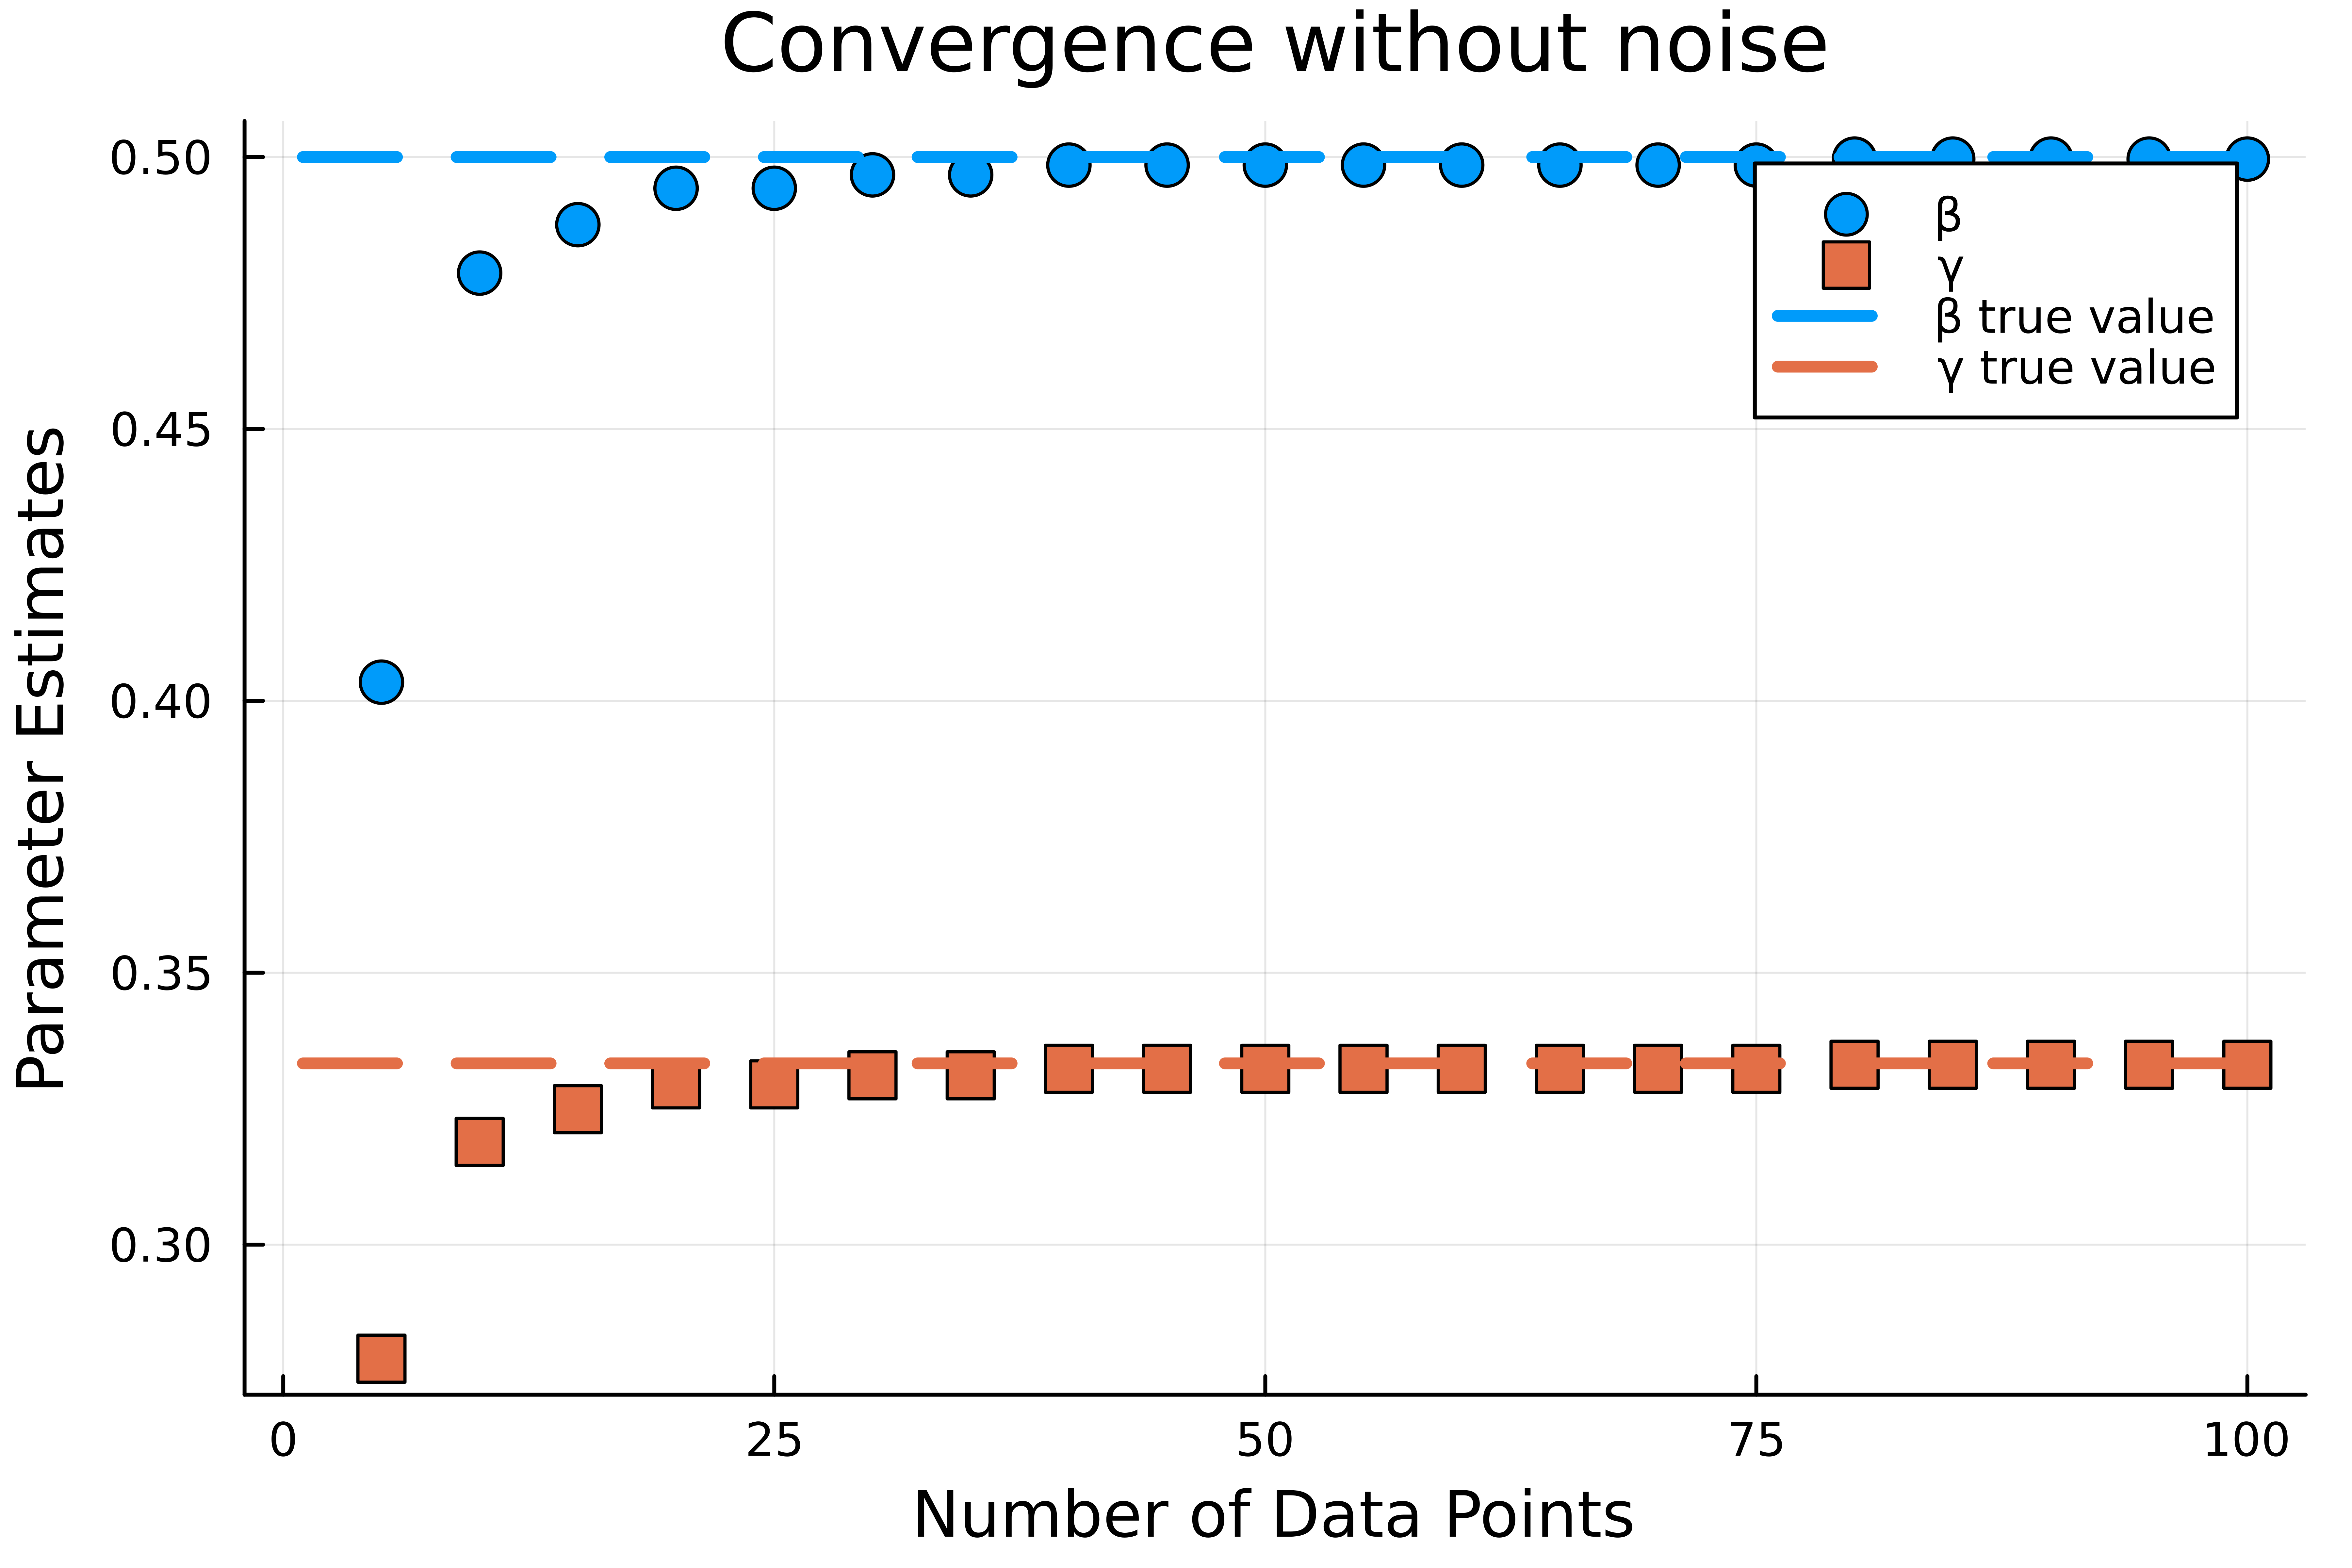

In [51]:
noise_vals = [0.0]
n_data_points = collect(5:5:100)
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

#parameter convergence without noise
marker_shapes = [:circle, :square, :diamond, :utriangle]
p1 = plot()
parameter_names = [string(param) for param in parameters(sys)]
x_values = collect(first.(keys(parameter_estimates)))
parameter_values = hcat([collect(values(parameter_estimates[n_data_points, 0.0])) for n_data_points in x_values]...)
scatter!(p1, x_values, parameter_values', label = hcat(parameter_names...), xlabel = "Number of Data Points", ylabel = "Parameter Estimates",
     title = "Convergence without noise", lw = 2, dpi = 1200, markershape = hcat(marker_shapes...), markersize = 6, legend = :topright)
#plot horizontal lines for true parameter values
for (i, param) in enumerate(parameters(sys))
    plot!(p1, [1, maximum(n_data_points)], repeat([p[param]], 2), label = "$(param) true value", ls = :dash, lw = 3, color = i)
end
#savefig("../plots/Lorenz_convergence_no_noise.png")
display(p1)

The convergence of the parameters is evaluated once again, but for different numbers of collocation points and noise levels. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves, and the noise level has a significant impact on the accuracy of the recovery.

In [58]:
rel_error_ests = copy(parameter_estimates)
#calculate relative errors
for ((n_data_points, noise_val), estimates) in parameter_estimates
    rel_error_ests[(n_data_points, noise_val)] = abs.(estimates .- values(p)) ./ abs.(values(p))
end

#
noise_vals = [0.0, 0.01, 0.05, 0.1]
n_data_points = [10, 10, 500, 100]
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

Dict{Tuple{Int64, Float64}, Vector{Float64}} with 12 entries:
  (500, 0.0)  => [0.499625, 0.333084]
  (10, 0.01)  => [0.476058, 0.318757]
  (10, 0.1)   => [0.46038, 0.303764]
  (100, 0.01) => [0.498982, 0.332779]
  (100, 0.1)  => [0.475373, 0.31634]
  (10, 0.0)   => [0.478659, 0.318895]
  (500, 0.05) => [0.494226, 0.329586]
  (100, 0.0)  => [0.499625, 0.333084]
  (10, 0.05)  => [0.474478, 0.313509]
  (500, 0.01) => [0.499138, 0.332687]
  (100, 0.05) => [0.489087, 0.326052]
  (500, 0.1)  => [0.478076, 0.314773]

### $\beta$ relative errors

In [59]:
using DataFrames
β_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 1)


Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,4.268,5.247,7.512,7.716
2,50,0.2954,0.03814,0.3227,7.073
3,150,0.07491,0.1514,0.8856,8.822
4,300,0.07491,0.04872,0.8847,7.987


### $\gamma$ relative errors

In [ ]:
γ_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 2)

Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,4.332,4.855,5.631,8.272
2,50,0.2964,0.3105,1.269,5.312
3,150,0.07481,0.1526,0.5451,5.552
4,300,0.07481,0.04377,0.9471,6.633
